# Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
# matplotlib.use('Agg')
sns.set_style("ticks")

from pprint import pprint
from itertools import product

# Utils

In [2]:
def smoother(x, a=0.0, w=10, mode="moving"):
    if mode == "moving":
        y = [x[0]]
        for i in range(1, len(x)):
            y.append((1 - a) * x[i] + a * y[i - 1])
    elif mode == "window":
        y = []
        for i in range(len(x)):
            y.append(np.mean(x[max(i - w, 0):i + 1]))
    return y


def plot_single(df, title=None):
    plt.figure(figsize=(4, 3), dpi=100)
    x = df["exploration/num steps total"].to_numpy() / 1e6
    y = smoother(df["evaluation/Average Returns"].to_numpy(), w=10, mode="window")
    plt.xlabel("Million Steps")
    plt.ylabel("Average Return")
    if title:
        plt.title(title)
    plt.plot(x, y)


def plot_multi(dfs, labels, title=None):
    plt.figure(figsize=(8, 6), dpi=100)
    for df, label in zip(dfs, labels):
        x = df["exploration/num steps total"].to_numpy() / 1e6
        y = smoother(df["evaluation/Average Returns"].to_numpy(), w=10, mode="window")
        plt.plot(x, y, label=label)
    plt.xlabel("Million Steps")
    plt.ylabel("Average Return")
    if title:
        plt.title(title)
    plt.legend()


def plot_curve(
        ax,
        dfs,
        label=None,
        shaded_err=False,
        shaded_std=True,
        shared_area=0.5,
        steps_per_epoch=1000,
        context="Return/Average",
        color="black",
        **plot_kwargs,
):
    N = np.min([len(df) for df in dfs])
    x = dfs[0]["Diagnostics/Iteration"].to_numpy()[:N] * steps_per_epoch / 1e6
    ys = [smoother(df[f"{context}"].to_numpy()[:N], a=0.95) for df in dfs]
    y_mean = np.mean(ys, axis=0)
    if label is None:
        lin = ax.plot(x, y_mean, color=color, **plot_kwargs)
        # plt.semilogy(x, y_mean, color=color)
    else:
        lin = ax.plot(x, y_mean, label=label, color=color, **plot_kwargs)
    if len(ys) > 1:
        y_std = np.std(ys, axis=0) * shared_area
        y_stderr = y_std / np.sqrt(len(ys))
        if shaded_err:
            ax.fill_between(x, y_mean - y_stderr, y_mean + y_stderr, color=color, alpha=.4)
        if shaded_std:
            ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=.2)
    return lin

def plot_curve_topk(
        ax,
        dfs,
        topk=3,
        label=None,
        shaded_err=False,
        shaded_std=True,
        shared_area=0.5,
        steps_per_epoch=1000,
        context="Return/Average",
        color="black",
        **plot_kwargs,
):
    N = np.min([len(df) for df in dfs])
    x = dfs[0]["Diagnostics/Iteration"].to_numpy()[:N] * steps_per_epoch / 1e6
#     ys = [smoother(df[f"{context}"].to_numpy()[:N], a=0.) for df in dfs]
    ys = [df[f"{context}"].to_numpy()[:N] for df in dfs]
    print(N, np.sort(np.array(ys), axis=0))
    ys = np.sort(np.array(ys), axis=0)[-topk:]
    y_mean = np.mean(ys, axis=0)
    if label is None:
        lin = ax.plot(x, y_mean, color=color, **plot_kwargs)
    else:
        lin = ax.plot(x, y_mean, label=label, color=color, **plot_kwargs)
    if len(ys) > 1:
        y_std = np.std(ys, axis=0) * shared_area
        y_stderr = y_std / np.sqrt(len(ys))
        if shaded_err:
            ax.fill_between(x, y_mean - y_stderr, y_mean + y_stderr, color=color, alpha=.4)
        if shaded_std:
            ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=.2)
    return lin

# Experienment

## Compare APO with discounted PPO

In [3]:
best_settings = []

# Discount
algo = "ppo"
discount_list = [0.9, 0.95, 0.99, 0.999]
gae_lambda_list = [0.8, 0.9, 0.95, 0.99]
seed_list = [0, 1, 2, 3, 4]
env_list = ["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]
from pprint import pprint
from itertools import product
for env, discount in product(env_list, discount_list):
    best_record = {}
    for gae_lambda in gae_lambda_list:
        basedir = "exp_0107/data"
        setting = f"{algo}_g-{discount}_l-{gae_lambda}_{env}"
        score = np.mean([
            pd.read_csv(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))['Return/Average'].max() for seed in seed_list])
        if score > best_record.get('score', -np.inf):
            best_record = dict(setting=setting, score=score)
    pprint(best_record)
    best_settings.append(best_record["setting"])

# Average
algo = "appo"
discount_list = [1.0]
gae_lambda_list = [0.8, 0.9, 0.95, 0.99]
seed_list = [1, 2, 3, 4]
lr_eta_list = [0.03, 0.1, 0.3]
rm_vb_coef_list = [0., 0.03, 0.1, 0.3, 1.0]
env_list = ["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]
from pprint import pprint
from itertools import product
for env in env_list:
    best_record = {}
    for discount, gae_lambda, lr_eta, rm_vb_coef in product(discount_list, gae_lambda_list, lr_eta_list, rm_vb_coef_list):
        basedir = "exp_0107/data"
        setting = f"{algo}_g-{discount}_l-{gae_lambda}_e-{lr_eta}_v-{rm_vb_coef}_{env}"
        scores = []
        for seed in seed_list:
            try:
                df = pd.read_csv(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
                scores.append(df['Return/Average'].max())
#                 scores.append(df['Reward/Average'].max())
            except:
                print(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
        score = np.nanmean(scores)
        if score > best_record.get('score', -np.inf):
            best_record = dict(setting=setting, score=score)
    pprint(best_record)
    best_settings.append(best_record["setting"])

{'score': 28.38200894077619, 'setting': 'ppo_g-0.9_l-0.8_highway-v0'}
{'score': 28.20119366690829, 'setting': 'ppo_g-0.95_l-0.8_highway-v0'}
{'score': 23.66894571632772, 'setting': 'ppo_g-0.99_l-0.9_highway-v0'}
{'score': 23.374419879082478, 'setting': 'ppo_g-0.999_l-0.8_highway-v0'}
{'score': 44.040003496393396, 'setting': 'ppo_g-0.9_l-0.95_Swimmer-v3'}
{'score': 45.027543728239635, 'setting': 'ppo_g-0.95_l-0.99_Swimmer-v3'}
{'score': 91.53293406065754, 'setting': 'ppo_g-0.99_l-0.99_Swimmer-v3'}
{'score': 275.6099096360065, 'setting': 'ppo_g-0.999_l-0.95_Swimmer-v3'}
{'score': 2091.672413492736, 'setting': 'ppo_g-0.9_l-0.99_HalfCheetah-v3'}
{'score': 2674.3970941948073, 'setting': 'ppo_g-0.95_l-0.99_HalfCheetah-v3'}
{'score': 2912.173574108443, 'setting': 'ppo_g-0.99_l-0.9_HalfCheetah-v3'}
{'score': 1612.5255698525016, 'setting': 'ppo_g-0.999_l-0.8_HalfCheetah-v3'}
{'score': 2213.0719998873737, 'setting': 'ppo_g-0.9_l-0.9_Ant-v3'}
{'score': 4446.09286057612, 'setting': 'ppo_g-0.95_l-0

appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3
ppo_g-0.9_l-0.95_Swimmer-v3
ppo_g-0.95_l-0.99_Swimmer-v3
ppo_g-0.99_l-0.99_Swimmer-v3
ppo_g-0.999_l-0.95_Swimmer-v3
appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3
ppo_g-0.9_l-0.99_HalfCheetah-v3
ppo_g-0.95_l-0.99_HalfCheetah-v3
ppo_g-0.99_l-0.9_HalfCheetah-v3
ppo_g-0.999_l-0.8_HalfCheetah-v3
appo_g-1.0_l-0.8_e-0.3_v-0.0_Ant-v3
ppo_g-0.9_l-0.9_Ant-v3
ppo_g-0.95_l-0.8_Ant-v3
ppo_g-0.99_l-0.8_Ant-v3
ppo_g-0.999_l-0.8_Ant-v3


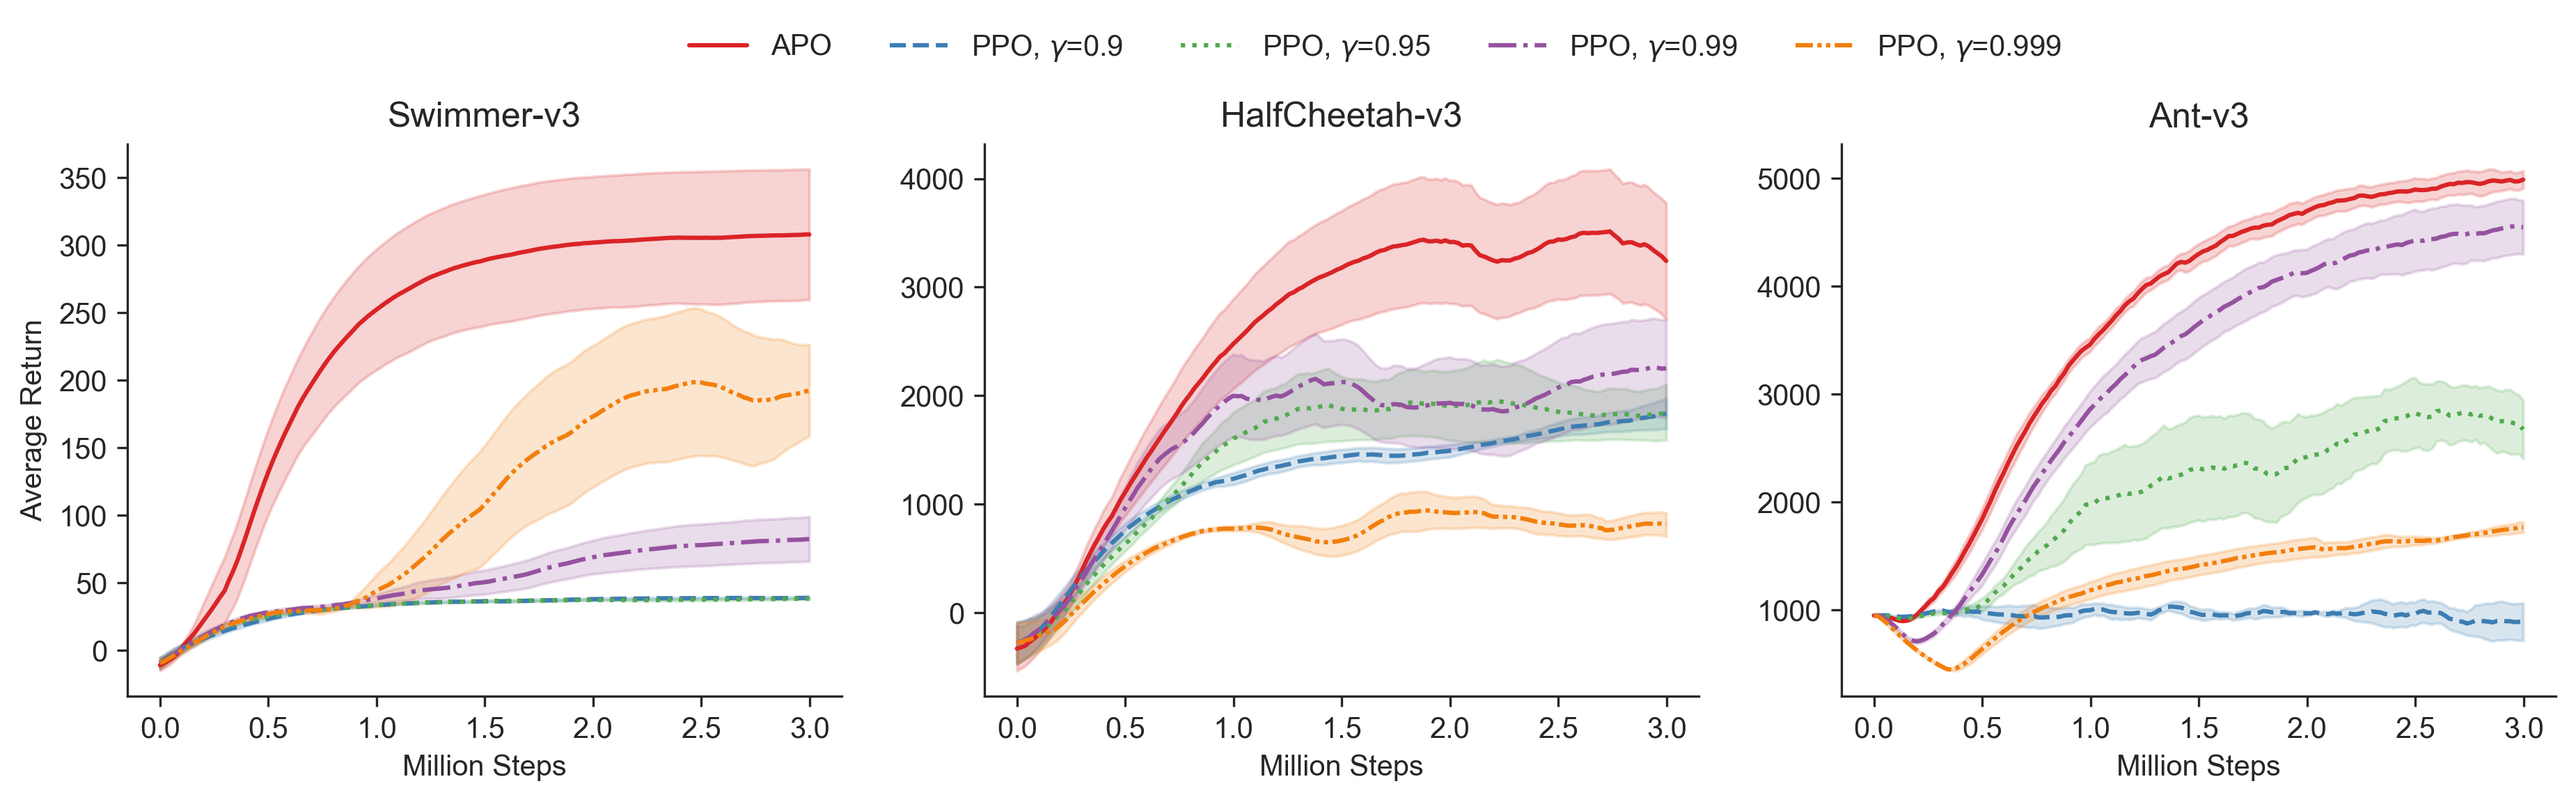

In [20]:
# compare PPO with different gamma
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", (0, (4, 1, 1, 1, 1, 1))]
fig = plt.figure(figsize=(15, 3.5), dpi=300)
fig.subplots_adjust(hspace=0.4)
# for j, env in enumerate(["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, env in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
# for j, env in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    for i, gamma in enumerate([1.0, 0.9, 0.95, 0.99, 0.999]):
        if gamma == 1.0:
            algo = "appo"
        else:
            algo = "ppo"
        basedir = "exp_0107/data"
        steps_per_epoch = 2000
        setting = [s for s in best_settings if env in s and f"_g-{gamma}_" in s][0]
        print(setting)
        dfs = [
                pd.read_csv(os.path.join(basedir, setting, subdir, "progress.csv"))
                for subdir in os.listdir(os.path.join(basedir, setting))
                if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
            ]
        if gamma == 1.0:
            label = "APO"
        else:
            label = r"PPO, $\gamma$=" + str(gamma)
        plot_curve(ax, 
                   dfs, 
                   label=label,
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
                   linestyle=LINES[i],
                   context="Return/Average")
#                     context="Reward/Average")
    ax.set_title(env)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="upper left", bbox_to_anchor=(0.75, 1.25), ncol=5, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
fig.savefig('result/mujoco.pdf', dpi=300, bbox_inches='tight')

appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3
ppo_g-0.9_l-0.95_Swimmer-v3
ppo_g-0.95_l-0.99_Swimmer-v3
ppo_g-0.99_l-0.99_Swimmer-v3
ppo_g-0.999_l-0.95_Swimmer-v3
appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3
ppo_g-0.9_l-0.99_HalfCheetah-v3
ppo_g-0.95_l-0.99_HalfCheetah-v3
ppo_g-0.99_l-0.9_HalfCheetah-v3
ppo_g-0.999_l-0.8_HalfCheetah-v3
appo_g-1.0_l-0.8_e-0.3_v-0.0_Ant-v3
ppo_g-0.9_l-0.9_Ant-v3
ppo_g-0.95_l-0.8_Ant-v3
ppo_g-0.99_l-0.8_Ant-v3
ppo_g-0.999_l-0.8_Ant-v3
appo_g-1.0_l-0.9_e-0.03_v-0.0_Hopper-v3
ppo_g-0.9_l-0.99_Hopper-v3
ppo_g-0.95_l-0.8_Hopper-v3
ppo_g-0.99_l-0.9_Hopper-v3
ppo_g-0.999_l-0.9_Hopper-v3
appo_g-1.0_l-0.8_e-0.03_v-0.0_Walker2d-v3
ppo_g-0.9_l-0.8_Walker2d-v3
ppo_g-0.95_l-0.95_Walker2d-v3
ppo_g-0.99_l-0.95_Walker2d-v3
ppo_g-0.999_l-0.8_Walker2d-v3
appo_g-1.0_l-0.95_e-0.03_v-0.0_Humanoid-v3
ppo_g-0.9_l-0.95_Humanoid-v3
ppo_g-0.95_l-0.99_Humanoid-v3
ppo_g-0.99_l-0.9_Humanoid-v3
ppo_g-0.999_l-0.95_Humanoid-v3


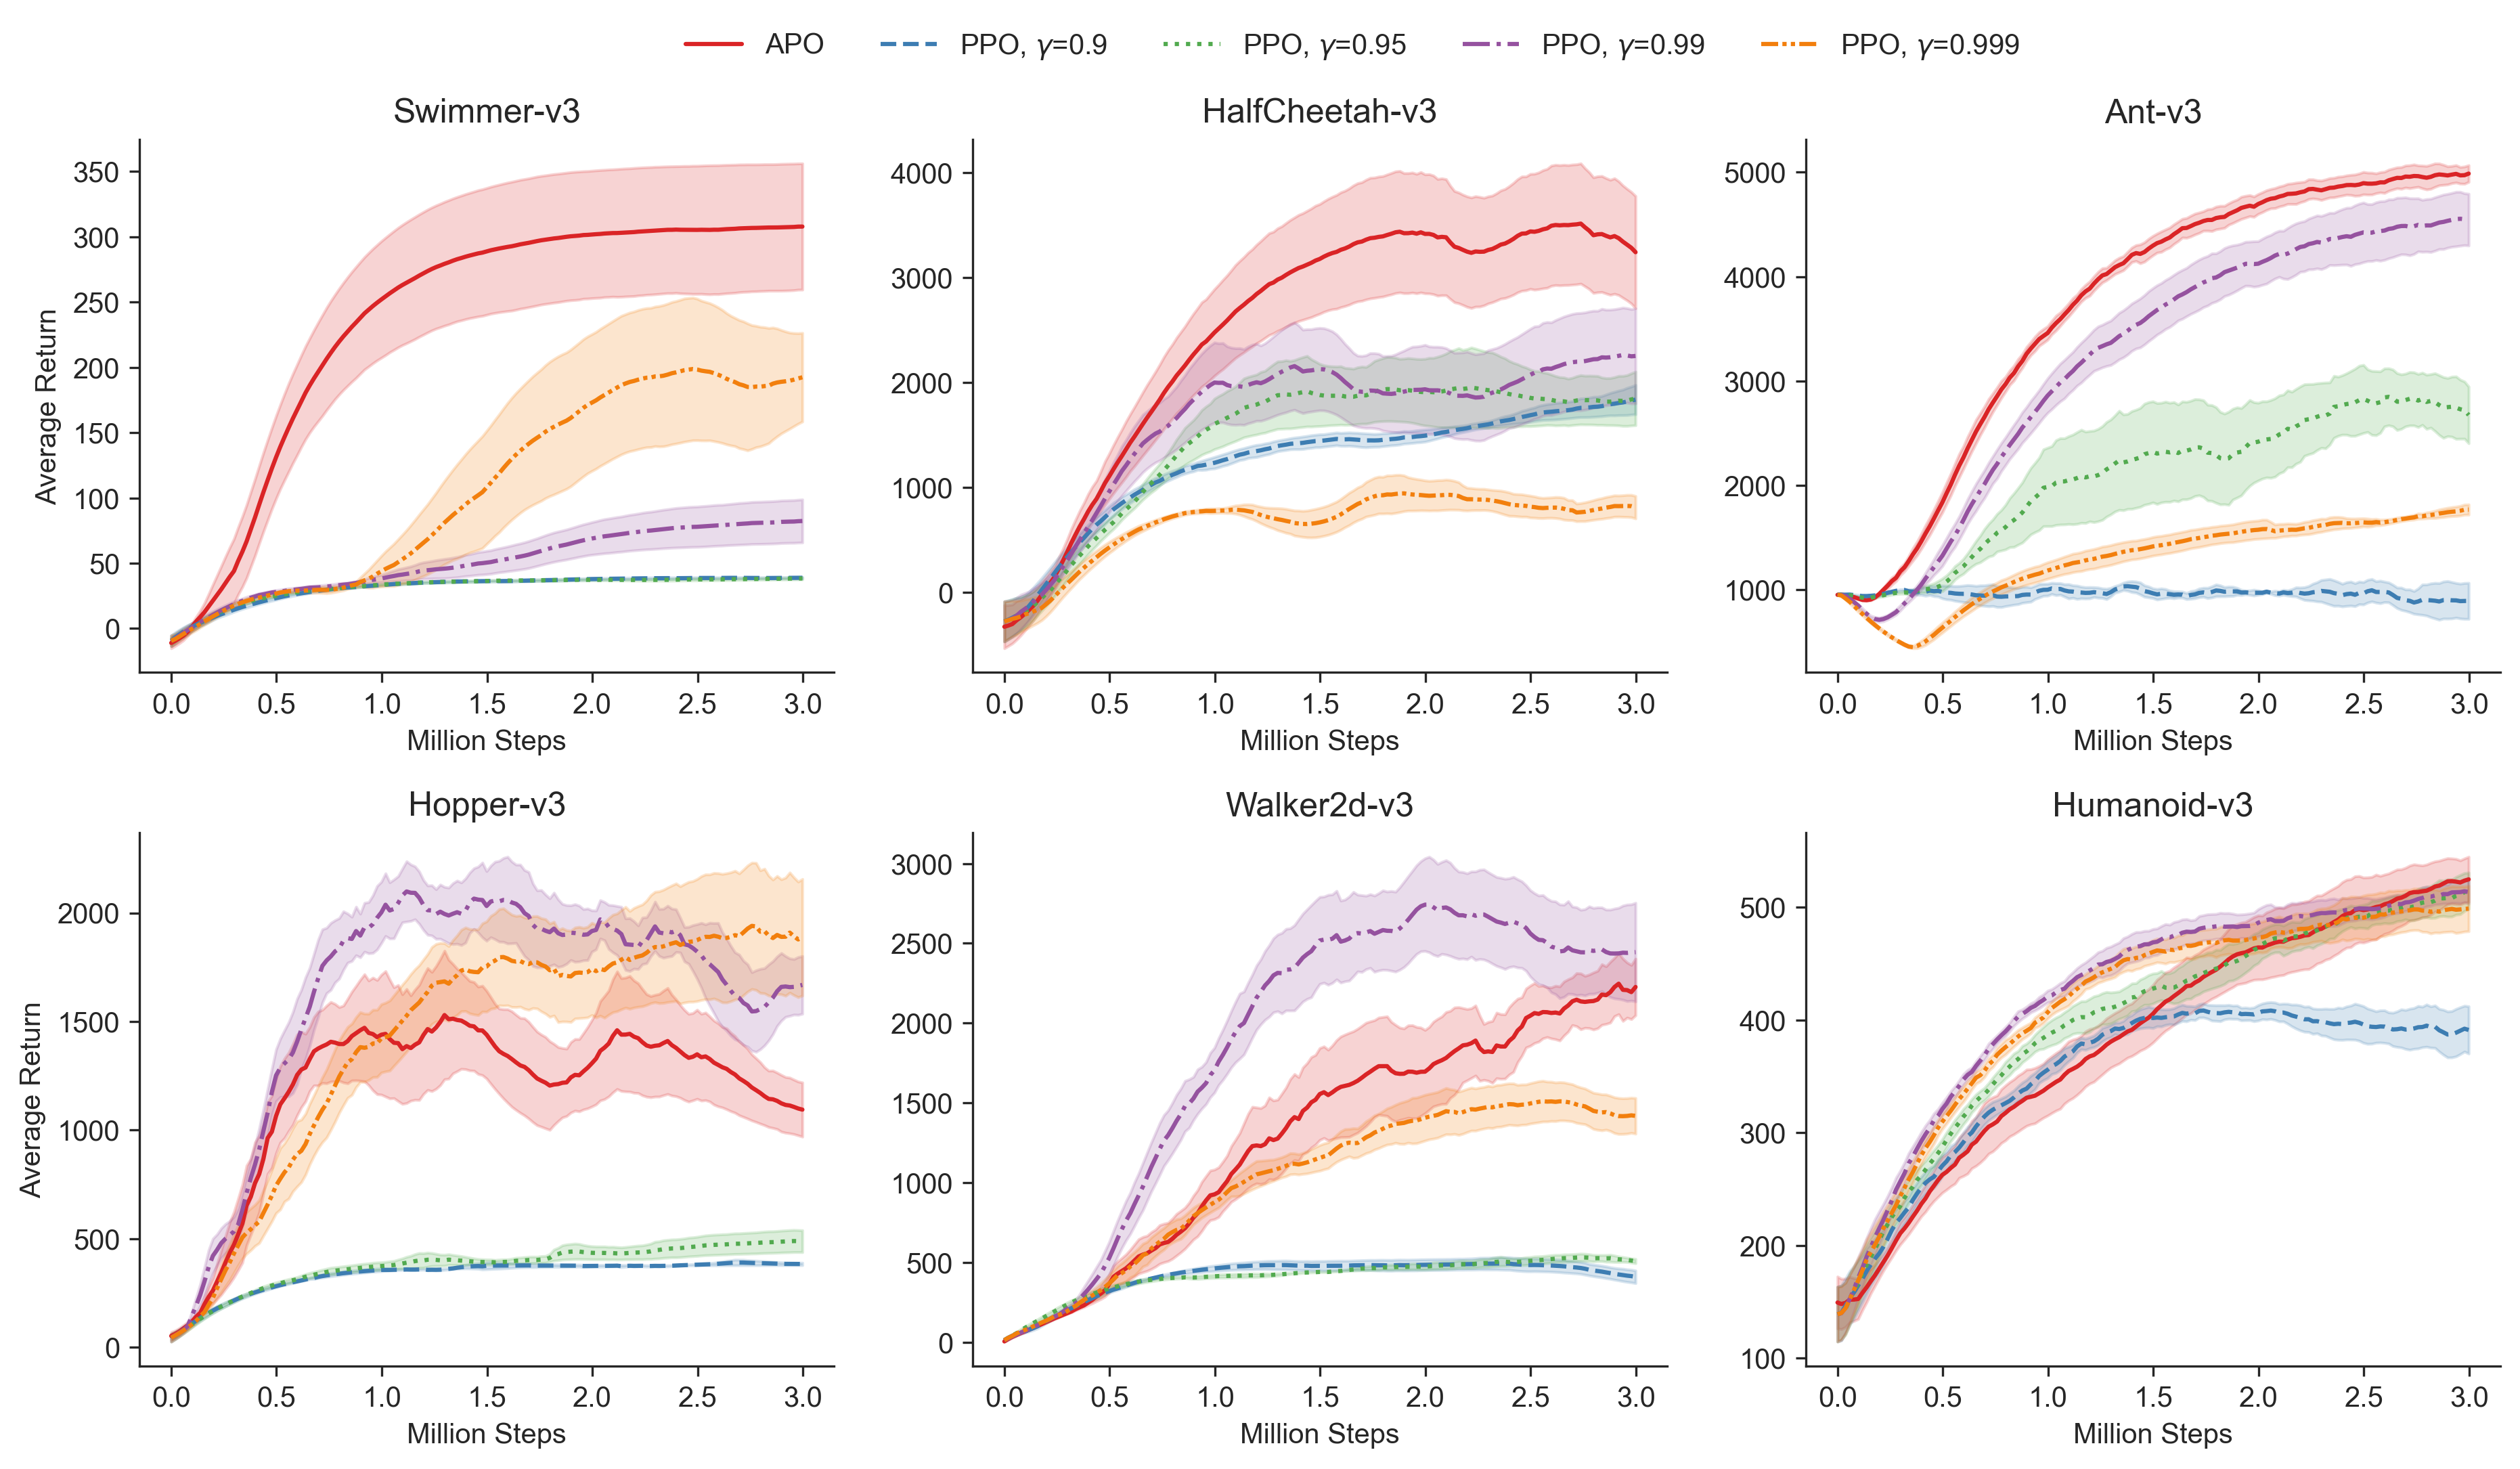

In [21]:
# compare PPO with different gamma
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", (0, (4, 1, 1, 1, 1, 1))]
fig = plt.figure(figsize=(15, 8), dpi=300)
fig.subplots_adjust(hspace=0.3)
# for j, env in enumerate(["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, env in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(2, 3, j + 1)
    for i, gamma in enumerate([1.0, 0.9, 0.95, 0.99, 0.999]):
        if gamma == 1.0:
            algo = "appo"
        else:
            algo = "ppo"
        basedir = "exp_0107/data"
        steps_per_epoch = 2000
        setting = [s for s in best_settings if env in s and f"_g-{gamma}_" in s][0]
        print(setting)
        dfs = [
                pd.read_csv(os.path.join(basedir, setting, subdir, "progress.csv"))
                for subdir in os.listdir(os.path.join(basedir, setting))
                if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
            ]
        if gamma == 1.0:
            label = "APO"
        else:
            label = r"PPO, $\gamma$=" + str(gamma)
        plot_curve(ax, 
                   dfs, 
                   label=label,
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
                   linestyle=LINES[i],
                   context="Return/Average")
#                     context="Reward/Average")
    ax.set_title(env)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="upper left", bbox_to_anchor=(0.75, 1.25), ncol=5, frameon=False)
    if j == 3:
        ax.set_ylabel("Average Return")
sns.despine()
plt.show()
fig.savefig('result/mujoco_return.pdf', dpi=300, bbox_inches='tight')

appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3
ppo_g-0.9_l-0.95_Swimmer-v3
ppo_g-0.95_l-0.99_Swimmer-v3
ppo_g-0.99_l-0.99_Swimmer-v3
ppo_g-0.999_l-0.95_Swimmer-v3
appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3
ppo_g-0.9_l-0.99_HalfCheetah-v3
ppo_g-0.95_l-0.99_HalfCheetah-v3
ppo_g-0.99_l-0.9_HalfCheetah-v3
ppo_g-0.999_l-0.8_HalfCheetah-v3
appo_g-1.0_l-0.8_e-0.3_v-0.0_Ant-v3
ppo_g-0.9_l-0.9_Ant-v3
ppo_g-0.95_l-0.8_Ant-v3
ppo_g-0.99_l-0.8_Ant-v3
ppo_g-0.999_l-0.8_Ant-v3
appo_g-1.0_l-0.9_e-0.03_v-0.0_Hopper-v3
ppo_g-0.9_l-0.99_Hopper-v3
ppo_g-0.95_l-0.8_Hopper-v3
ppo_g-0.99_l-0.9_Hopper-v3
ppo_g-0.999_l-0.9_Hopper-v3
appo_g-1.0_l-0.8_e-0.03_v-0.0_Walker2d-v3
ppo_g-0.9_l-0.8_Walker2d-v3
ppo_g-0.95_l-0.95_Walker2d-v3
ppo_g-0.99_l-0.95_Walker2d-v3
ppo_g-0.999_l-0.8_Walker2d-v3
appo_g-1.0_l-0.95_e-0.03_v-0.0_Humanoid-v3
ppo_g-0.9_l-0.95_Humanoid-v3
ppo_g-0.95_l-0.99_Humanoid-v3
ppo_g-0.99_l-0.9_Humanoid-v3
ppo_g-0.999_l-0.95_Humanoid-v3


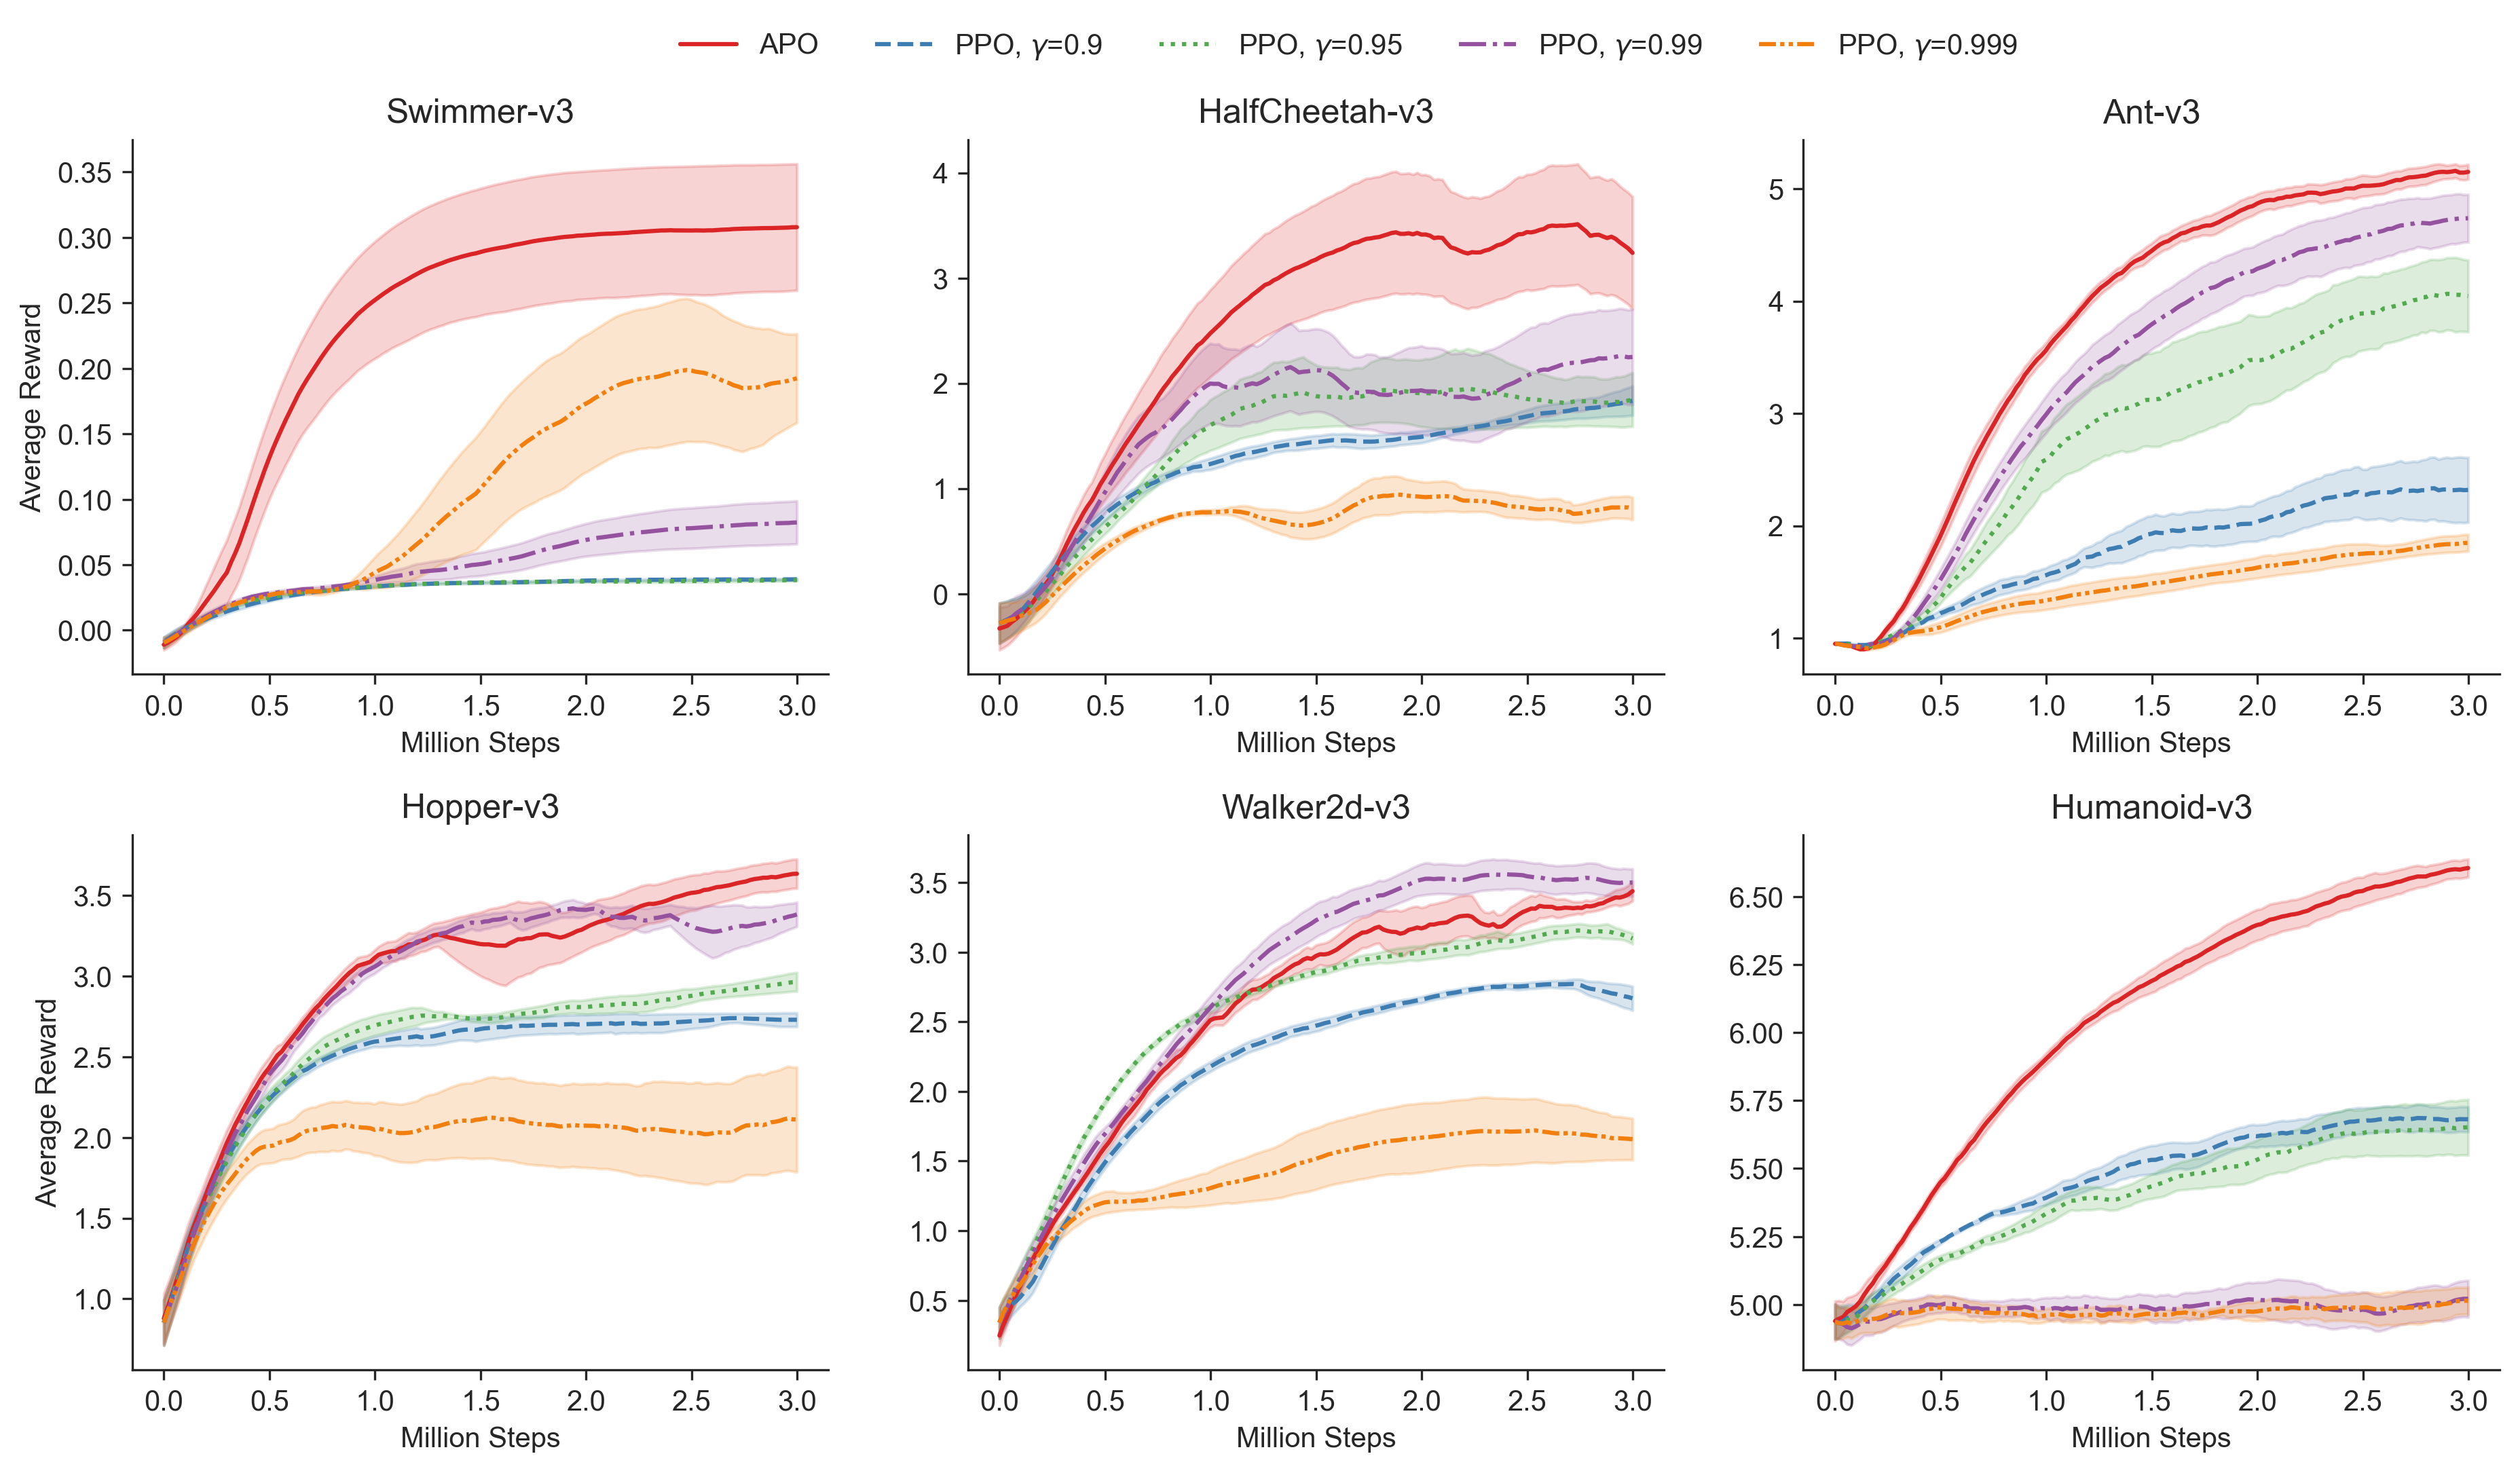

In [24]:
# compare PPO with different gamma
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", (0, (4, 1, 1, 1, 1, 1))]
fig = plt.figure(figsize=(15, 8), dpi=300)
fig.subplots_adjust(hspace=0.3)
# for j, env in enumerate(["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, env in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(2, 3, j + 1)
    for i, gamma in enumerate([1.0, 0.9, 0.95, 0.99, 0.999]):
        if gamma == 1.0:
            algo = "appo"
        else:
            algo = "ppo"
        basedir = "exp_0107/data"
        steps_per_epoch = 2000
        setting = [s for s in best_settings if env in s and f"_g-{gamma}_" in s][0]
        print(setting)
        dfs = [
                pd.read_csv(os.path.join(basedir, setting, subdir, "progress.csv"))
                for subdir in os.listdir(os.path.join(basedir, setting))
                if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
            ]
        if gamma == 1.0:
            label = "APO"
        else:
            label = r"PPO, $\gamma$=" + str(gamma)
        plot_curve(ax, 
                   dfs, 
                   label=label,
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
                   linestyle=LINES[i],
#                    context="Return/Average")
                    context="Reward/Average")
    ax.set_title(env)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Reward")
        ax.legend(loc="upper left", bbox_to_anchor=(0.75, 1.25), ncol=5, frameon=False)
    if j == 3:
        ax.set_ylabel("Average Reward")
sns.despine()
plt.show()
fig.savefig('result/mujoco_reward.pdf', dpi=300, bbox_inches='tight')

## Ablation of lr_eta

In [7]:
best_settings_lr_eta = []
algo = "appo"
discount_list = [1.0]
gae_lambda_list = [0.8, 0.9, 0.95, 0.99]
seed_list = [1, 2, 3, 4]
lr_eta_list = [0.03, 0.1, 0.3]
rm_vb_coef_list = [0., 0.03, 0.1, 0.3, 1.0]
env_list = ["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]
for env, lr_eta in product(env_list, lr_eta_list):
    best_record = {}
    for discount, gae_lambda, rm_vb_coef in product(discount_list, gae_lambda_list, rm_vb_coef_list):
        basedir = "exp_0107/data"
        setting = f"{algo}_g-{discount}_l-{gae_lambda}_e-{lr_eta}_v-{rm_vb_coef}_{env}"
        scores = []
        for seed in seed_list:
            try:
                df = pd.read_csv(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
                scores.append(df['Return/Average'].max())
            except:
                print(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
        score = np.nanmean(scores)
        if score > best_record.get('score', -np.inf):
            best_record = dict(setting=setting, score=score)
    pprint(best_record)
    best_settings_lr_eta.append(best_record["setting"])

best_settings_lr_eta

{'score': 28.732835310697553,
 'setting': 'appo_g-1.0_l-0.8_e-0.03_v-1.0_highway-v0'}
{'score': 28.911195316910742,
 'setting': 'appo_g-1.0_l-0.8_e-0.1_v-1.0_highway-v0'}
{'score': 29.08409968316555,
 'setting': 'appo_g-1.0_l-0.8_e-0.3_v-1.0_highway-v0'}
{'score': 314.89381210639846,
 'setting': 'appo_g-1.0_l-0.99_e-0.03_v-0.0_Swimmer-v3'}
{'score': 311.4901292752871,
 'setting': 'appo_g-1.0_l-0.99_e-0.1_v-1.0_Swimmer-v3'}
{'score': 315.20545086681375,
 'setting': 'appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3'}
{'score': 3104.579458825875,
 'setting': 'appo_g-1.0_l-0.9_e-0.03_v-0.03_HalfCheetah-v3'}
{'score': 3312.4886611623806,
 'setting': 'appo_g-1.0_l-0.9_e-0.1_v-0.1_HalfCheetah-v3'}
{'score': 4040.3155916885935,
 'setting': 'appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3'}
{'score': 4867.676646626066, 'setting': 'appo_g-1.0_l-0.8_e-0.03_v-0.03_Ant-v3'}
{'score': 5390.81188154382, 'setting': 'appo_g-1.0_l-0.8_e-0.1_v-0.03_Ant-v3'}
{'score': 5584.111628662718, 'setting': 'appo_g-1.0_l-0.8_

['appo_g-1.0_l-0.8_e-0.03_v-1.0_highway-v0',
 'appo_g-1.0_l-0.8_e-0.1_v-1.0_highway-v0',
 'appo_g-1.0_l-0.8_e-0.3_v-1.0_highway-v0',
 'appo_g-1.0_l-0.99_e-0.03_v-0.0_Swimmer-v3',
 'appo_g-1.0_l-0.99_e-0.1_v-1.0_Swimmer-v3',
 'appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3',
 'appo_g-1.0_l-0.9_e-0.03_v-0.03_HalfCheetah-v3',
 'appo_g-1.0_l-0.9_e-0.1_v-0.1_HalfCheetah-v3',
 'appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3',
 'appo_g-1.0_l-0.8_e-0.03_v-0.03_Ant-v3',
 'appo_g-1.0_l-0.8_e-0.1_v-0.03_Ant-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.0_Ant-v3',
 'appo_g-1.0_l-0.9_e-0.03_v-0.0_Hopper-v3',
 'appo_g-1.0_l-0.8_e-0.1_v-0.0_Hopper-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.0_Hopper-v3',
 'appo_g-1.0_l-0.8_e-0.03_v-0.0_Walker2d-v3',
 'appo_g-1.0_l-0.8_e-0.1_v-0.0_Walker2d-v3',
 'appo_g-1.0_l-0.9_e-0.3_v-0.0_Walker2d-v3',
 'appo_g-1.0_l-0.95_e-0.03_v-0.0_Humanoid-v3',
 'appo_g-1.0_l-0.8_e-0.1_v-0.03_Humanoid-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.03_Humanoid-v3']

appo_g-1.0_l-0.8_e-0.03_v-1.0_highway-v0
appo_g-1.0_l-0.8_e-0.1_v-1.0_highway-v0
appo_g-1.0_l-0.8_e-0.3_v-1.0_highway-v0
appo_g-1.0_l-0.99_e-0.03_v-0.0_Swimmer-v3
appo_g-1.0_l-0.99_e-0.1_v-1.0_Swimmer-v3
appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3
appo_g-1.0_l-0.9_e-0.03_v-0.03_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.1_v-0.1_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3


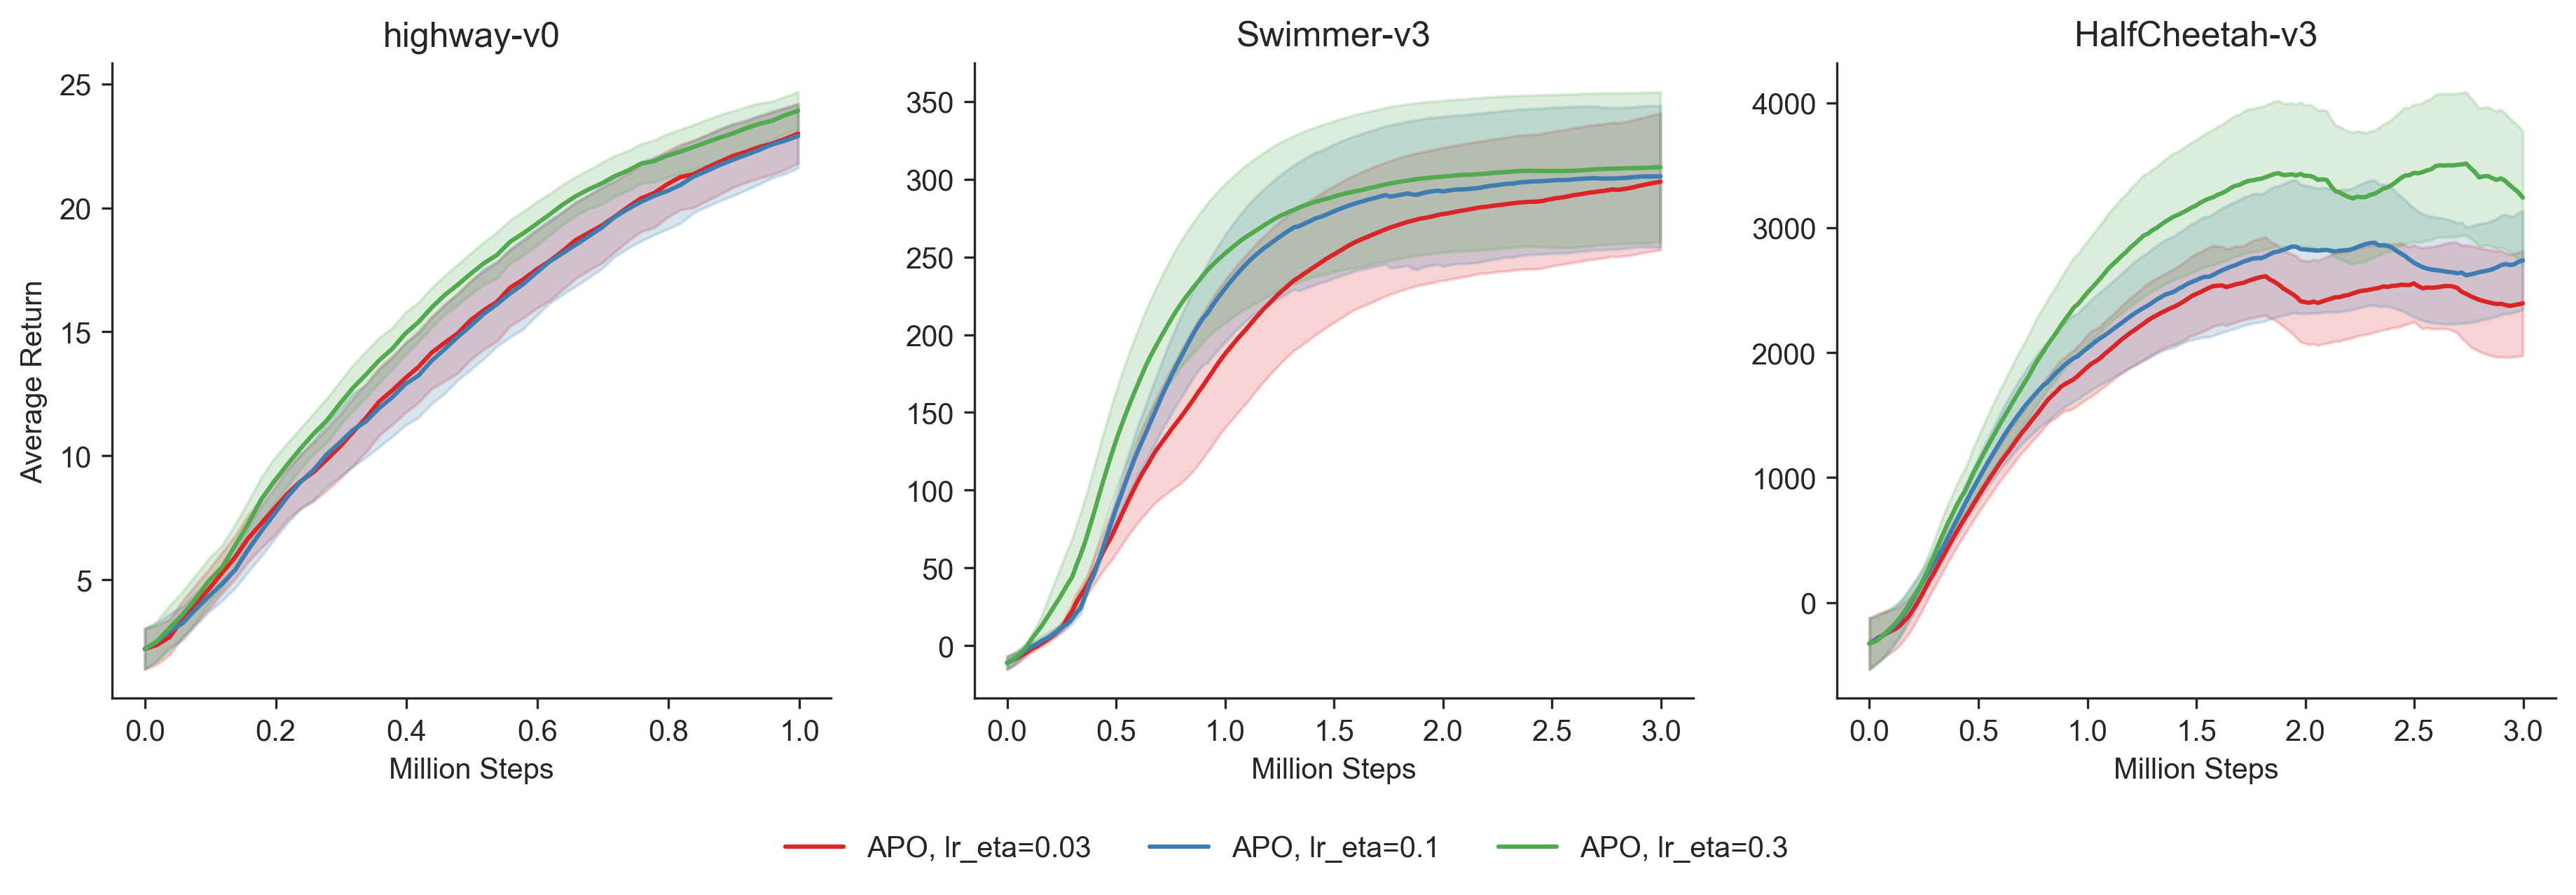

In [8]:
# compare APO with different lr_eta
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
for j, env in enumerate(["highway-v0", "Swimmer-v3", "HalfCheetah-v3"]):
# for j, env in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
# for j, env in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    for i, lr_eta in enumerate([0.03, 0.1, 0.3]):
        basedir = "exp_0107/data"
        steps_per_epoch = 2000
        setting = [s for s in best_settings_lr_eta if env in s and f"_e-{lr_eta}_" in s][0]
        print(setting)
        dfs = [
                pd.read_csv(os.path.join(basedir, setting, subdir, "progress.csv"))
                for subdir in os.listdir(os.path.join(basedir, setting))
                if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
            ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APO, lr_eta=" + str(lr_eta), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
    ax.set_title(env)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.9, -0.3), ncol=3, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

## Ablation of rm_vb_coef

In [9]:
best_settings_rm_vb_coef = []
algo = "appo"
discount_list = [1.0]
gae_lambda_list = [0.8, 0.9, 0.95, 0.99]
seed_list = [1, 2, 3, 4]
lr_eta_list = [0.03, 0.1, 0.3]
rm_vb_coef_list = [0., 0.03, 0.1, 0.3, 1.0]
env_list = ["highway-v0", "Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]
from pprint import pprint
from itertools import product
for env, rm_vb_coef in product(env_list, rm_vb_coef_list):
    best_record = {}
    for discount, gae_lambda, lr_eta in product(discount_list, gae_lambda_list, lr_eta_list):
        basedir = "exp_0107/data"
        setting = f"{algo}_g-{discount}_l-{gae_lambda}_e-{lr_eta}_v-{rm_vb_coef}_{env}"
        scores = []
        for seed in seed_list:
            try:
                df = pd.read_csv(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
                scores.append(df['Return/Average'].max())
            except:
                print(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
        score = np.nanmean(scores)
        if score > best_record.get('score', -np.inf):
            best_record = dict(setting=setting, score=score)
    pprint(best_record)
    best_settings_rm_vb_coef.append(best_record["setting"])
best_settings_rm_vb_coef

{'score': 28.28942855894566,
 'setting': 'appo_g-1.0_l-0.8_e-0.3_v-0.0_highway-v0'}
{'score': 27.933706168830394,
 'setting': 'appo_g-1.0_l-0.8_e-0.3_v-0.03_highway-v0'}
{'score': 28.41269977390766,
 'setting': 'appo_g-1.0_l-0.8_e-0.03_v-0.1_highway-v0'}
{'score': 28.478914837539197,
 'setting': 'appo_g-1.0_l-0.8_e-0.03_v-0.3_highway-v0'}
{'score': 29.08409968316555,
 'setting': 'appo_g-1.0_l-0.8_e-0.3_v-1.0_highway-v0'}
{'score': 314.89381210639846,
 'setting': 'appo_g-1.0_l-0.99_e-0.03_v-0.0_Swimmer-v3'}
{'score': 315.20545086681375,
 'setting': 'appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3'}
{'score': 267.50483620778266,
 'setting': 'appo_g-1.0_l-0.95_e-0.3_v-0.1_Swimmer-v3'}
{'score': 266.5770059474984,
 'setting': 'appo_g-1.0_l-0.95_e-0.3_v-0.3_Swimmer-v3'}
{'score': 311.4901292752871,
 'setting': 'appo_g-1.0_l-0.99_e-0.1_v-1.0_Swimmer-v3'}
{'score': 2934.866217283985,
 'setting': 'appo_g-1.0_l-0.95_e-0.1_v-0.0_HalfCheetah-v3'}
{'score': 3104.579458825875,
 'setting': 'appo_g-1.0_l-0

['appo_g-1.0_l-0.8_e-0.3_v-0.0_highway-v0',
 'appo_g-1.0_l-0.8_e-0.3_v-0.03_highway-v0',
 'appo_g-1.0_l-0.8_e-0.03_v-0.1_highway-v0',
 'appo_g-1.0_l-0.8_e-0.03_v-0.3_highway-v0',
 'appo_g-1.0_l-0.8_e-0.3_v-1.0_highway-v0',
 'appo_g-1.0_l-0.99_e-0.03_v-0.0_Swimmer-v3',
 'appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3',
 'appo_g-1.0_l-0.95_e-0.3_v-0.1_Swimmer-v3',
 'appo_g-1.0_l-0.95_e-0.3_v-0.3_Swimmer-v3',
 'appo_g-1.0_l-0.99_e-0.1_v-1.0_Swimmer-v3',
 'appo_g-1.0_l-0.95_e-0.1_v-0.0_HalfCheetah-v3',
 'appo_g-1.0_l-0.9_e-0.03_v-0.03_HalfCheetah-v3',
 'appo_g-1.0_l-0.95_e-0.3_v-0.1_HalfCheetah-v3',
 'appo_g-1.0_l-0.9_e-0.1_v-0.3_HalfCheetah-v3',
 'appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.0_Ant-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.03_Ant-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.1_Ant-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-0.3_Ant-v3',
 'appo_g-1.0_l-0.8_e-0.3_v-1.0_Ant-v3',
 'appo_g-1.0_l-0.9_e-0.03_v-0.0_Hopper-v3',
 'appo_g-1.0_l-0.95_e-0.03_v-0.03_Hopper-v3',
 'appo_g-1.0_l-

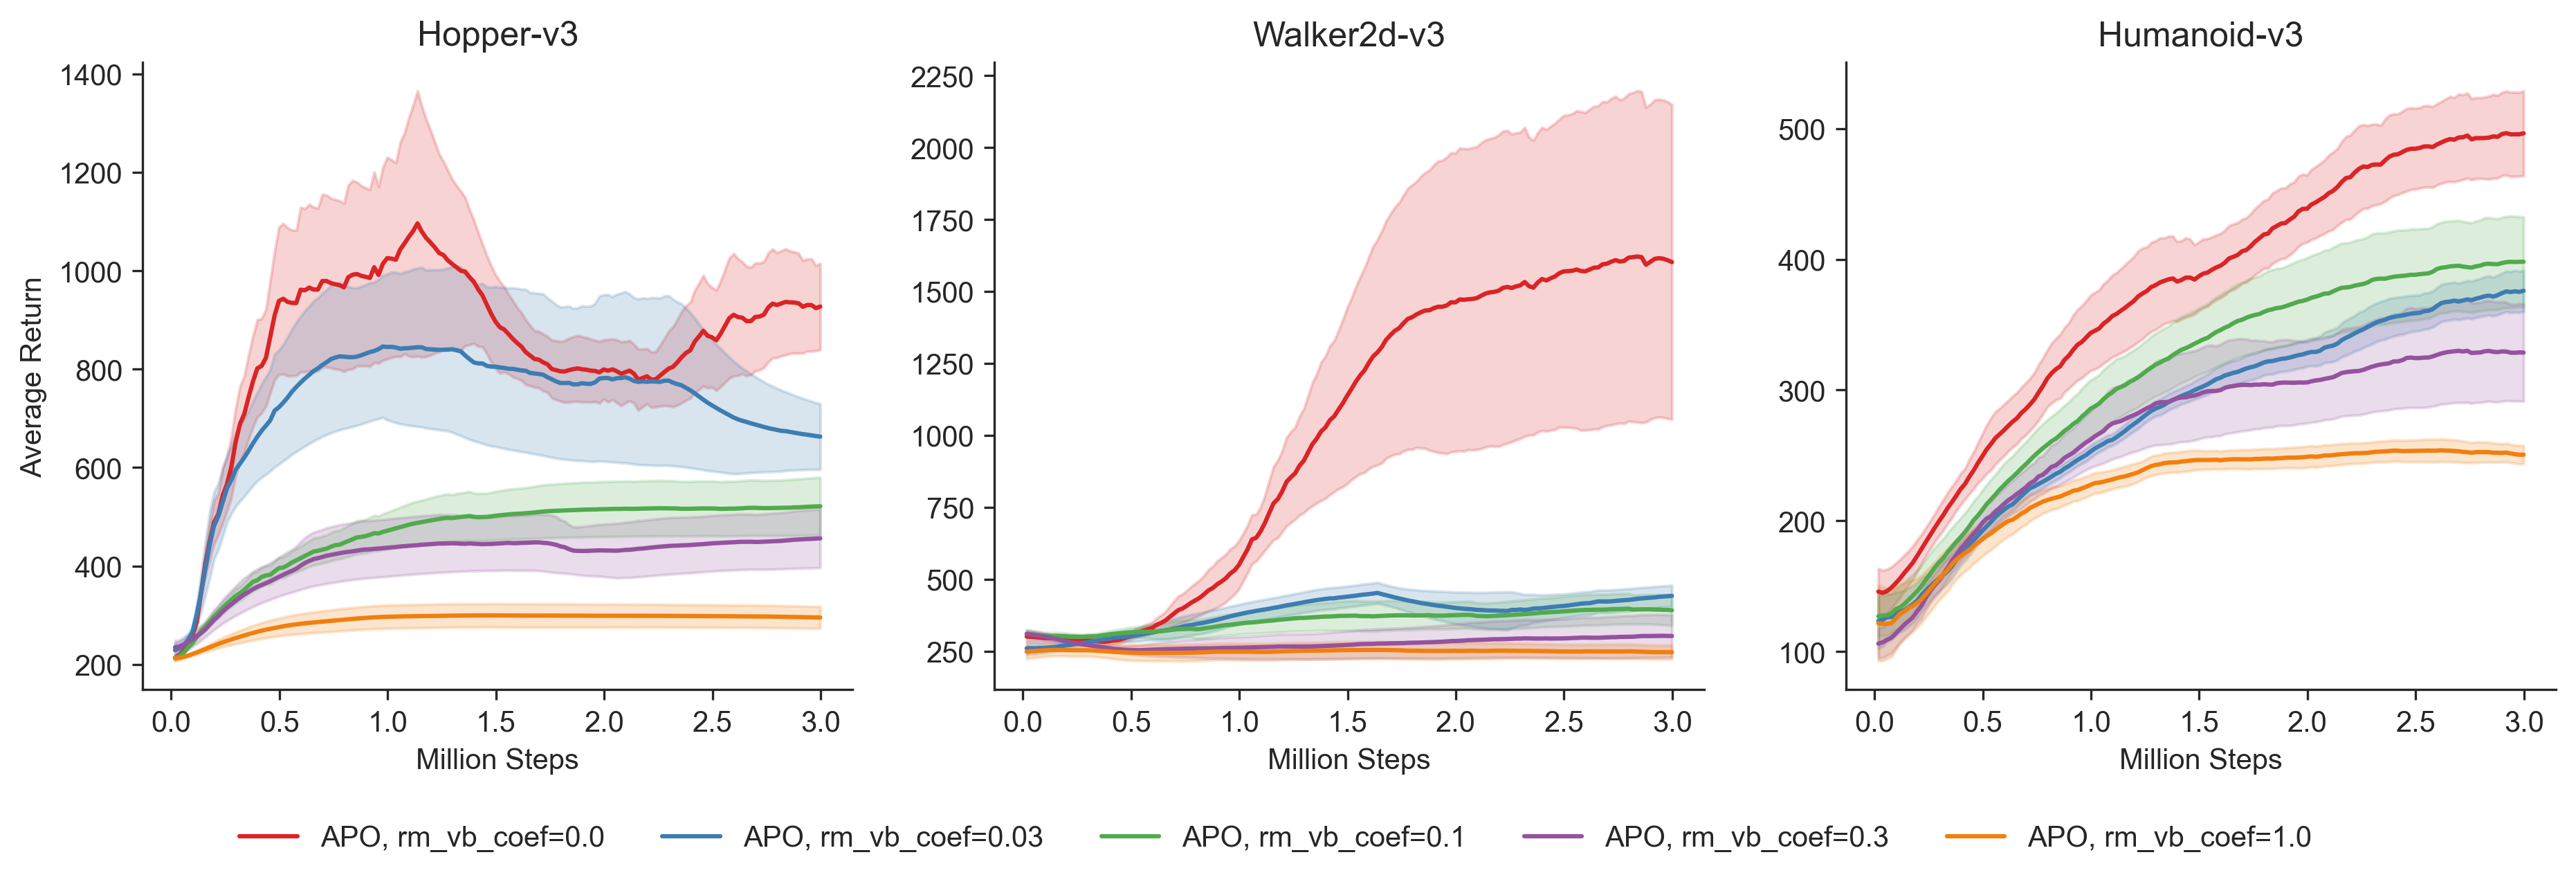

In [10]:
# compare APPO with different rm_vb_coef
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
# for j, env in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, env in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    gamma=1.0
    lamda = 0.95
    lr_eta=0.1
    for i, rm_vb_coef in enumerate([0.0, 0.03, 0.1, 0.3, 1.0]):
        steps_per_epoch = 2000
        basedir = f"exp_0107/data/{algo}_g-{gamma}_l-{lamda}_e-{lr_eta}_v-{rm_vb_coef}_{env}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv"))[1:] for subdir in os.listdir(basedir)
            if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APO, rm_vb_coef=" + str(rm_vb_coef), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
#                      context="Reward/Average")
#                    context="valueBias/Average")
    ax.set_title(env)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
#         ax.set_ylabel("Value Bias")
        ax.legend(loc="lower left", bbox_to_anchor=(0.1, -0.3), ncol=5, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

appo_g-1.0_l-0.99_e-0.03_v-0.0_Swimmer-v3
appo_g-1.0_l-0.99_e-0.3_v-0.03_Swimmer-v3
appo_g-1.0_l-0.95_e-0.3_v-0.1_Swimmer-v3
appo_g-1.0_l-0.95_e-0.3_v-0.3_Swimmer-v3
appo_g-1.0_l-0.99_e-0.1_v-1.0_Swimmer-v3
appo_g-1.0_l-0.95_e-0.1_v-0.0_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.03_v-0.03_HalfCheetah-v3
appo_g-1.0_l-0.95_e-0.3_v-0.1_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.1_v-0.3_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3
appo_g-1.0_l-0.8_e-0.3_v-0.0_Ant-v3
appo_g-1.0_l-0.8_e-0.3_v-0.03_Ant-v3
appo_g-1.0_l-0.8_e-0.3_v-0.1_Ant-v3
appo_g-1.0_l-0.8_e-0.3_v-0.3_Ant-v3
appo_g-1.0_l-0.8_e-0.3_v-1.0_Ant-v3


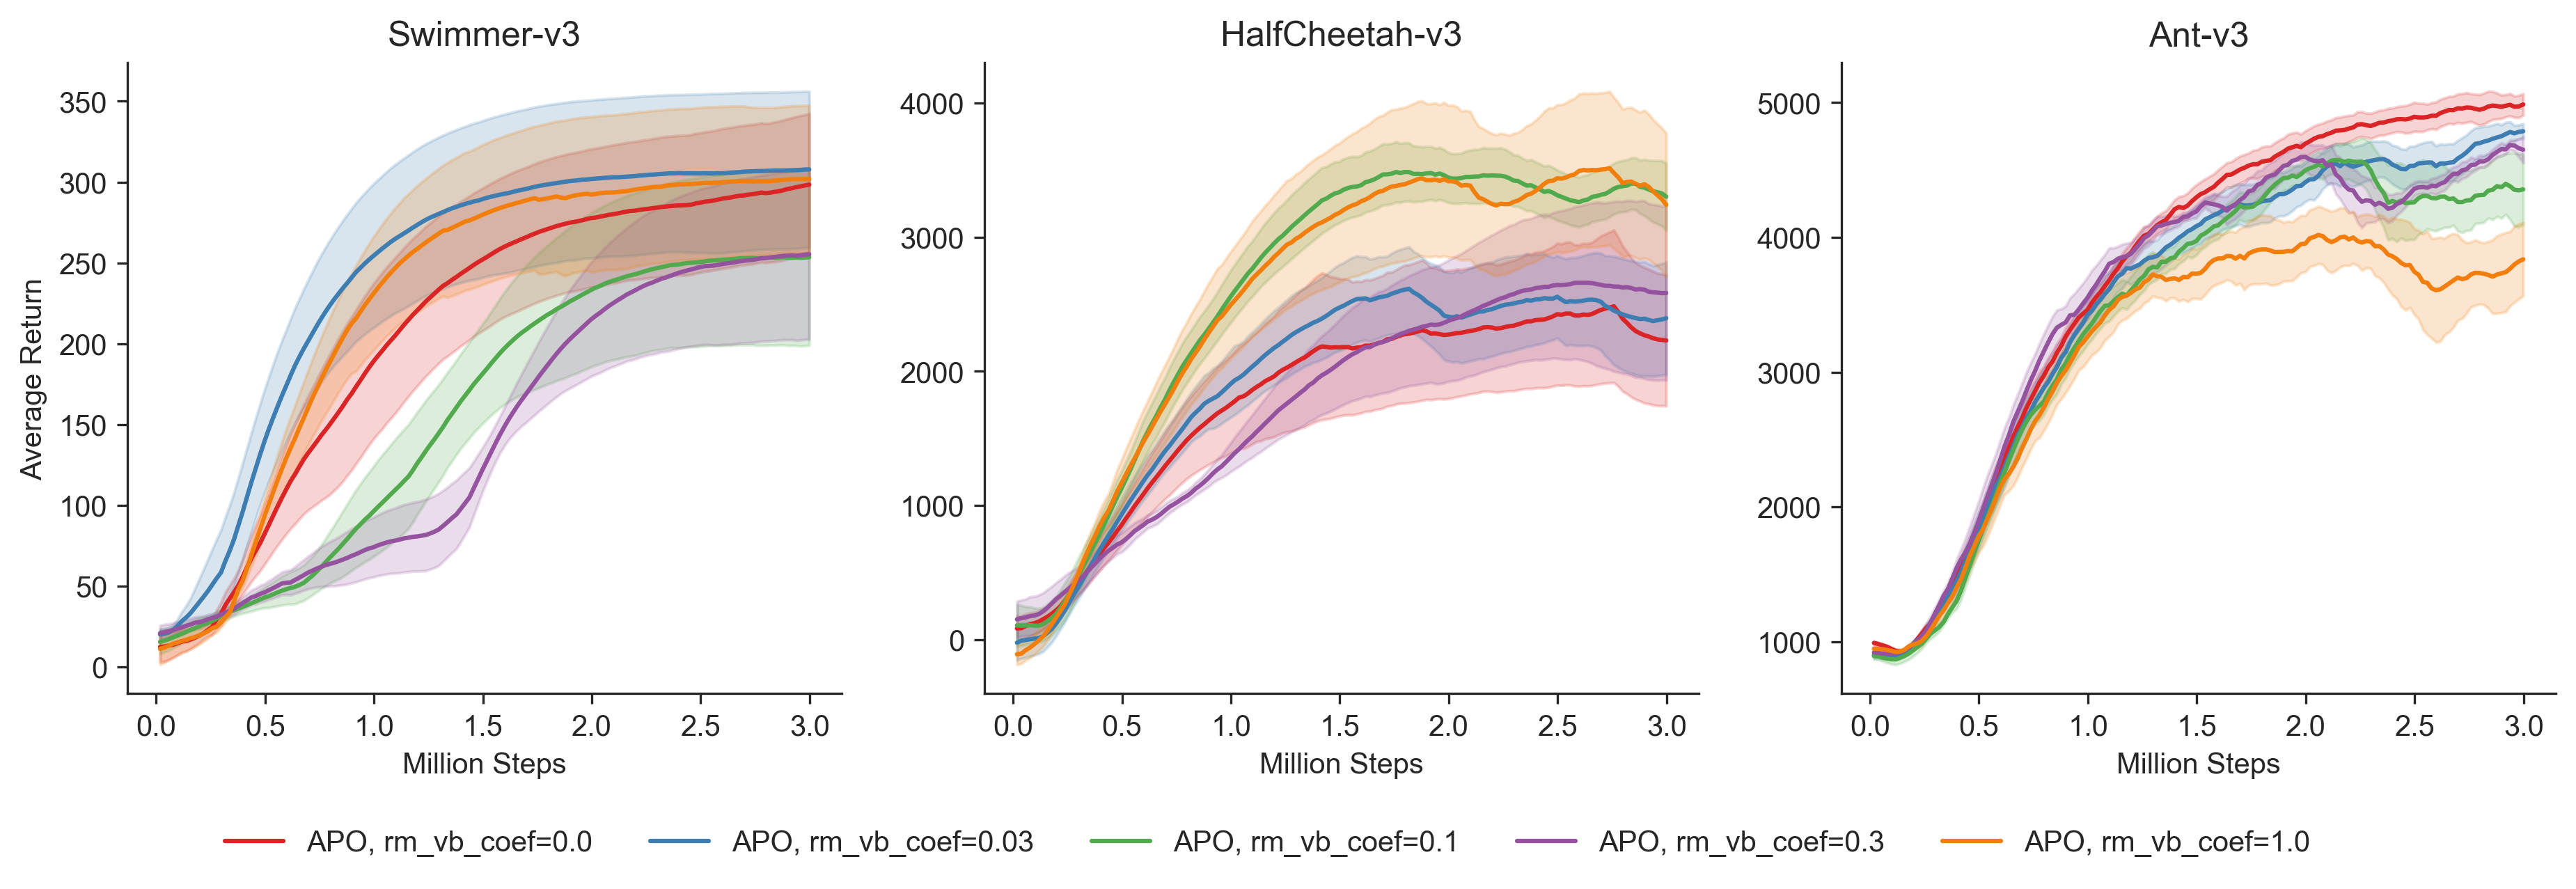

In [11]:
# compare APPO with different rm_vb_coef
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
for j, env in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
# for j, env in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    for i, rm_vb_coef in enumerate([0.0, 0.03, 0.1, 0.3, 1.0]):
        basedir = "exp_0107/data"
        steps_per_epoch = 2000
        setting = [s for s in best_settings_rm_vb_coef if env in s and f"_v-{rm_vb_coef}_" in s][0]
        print(setting)
        dfs = [
                pd.read_csv(os.path.join(basedir, setting, subdir, "progress.csv"))[1:]
                for subdir in os.listdir(os.path.join(basedir, setting))
                if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
            ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APO, rm_vb_coef=" + str(rm_vb_coef), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
#                      context="Reward/Average")
#                    context="valueBias/Average")
    ax.set_title(env)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
#         ax.set_ylabel("Value Bias")
        ax.legend(loc="lower left", bbox_to_anchor=(0.1, -0.3), ncol=5, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

appo_g-1.0_l-0.95_e-0.1_v-0.0_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.03_v-0.03_HalfCheetah-v3
appo_g-1.0_l-0.95_e-0.3_v-0.1_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.1_v-0.3_HalfCheetah-v3
appo_g-1.0_l-0.9_e-0.3_v-1.0_HalfCheetah-v3


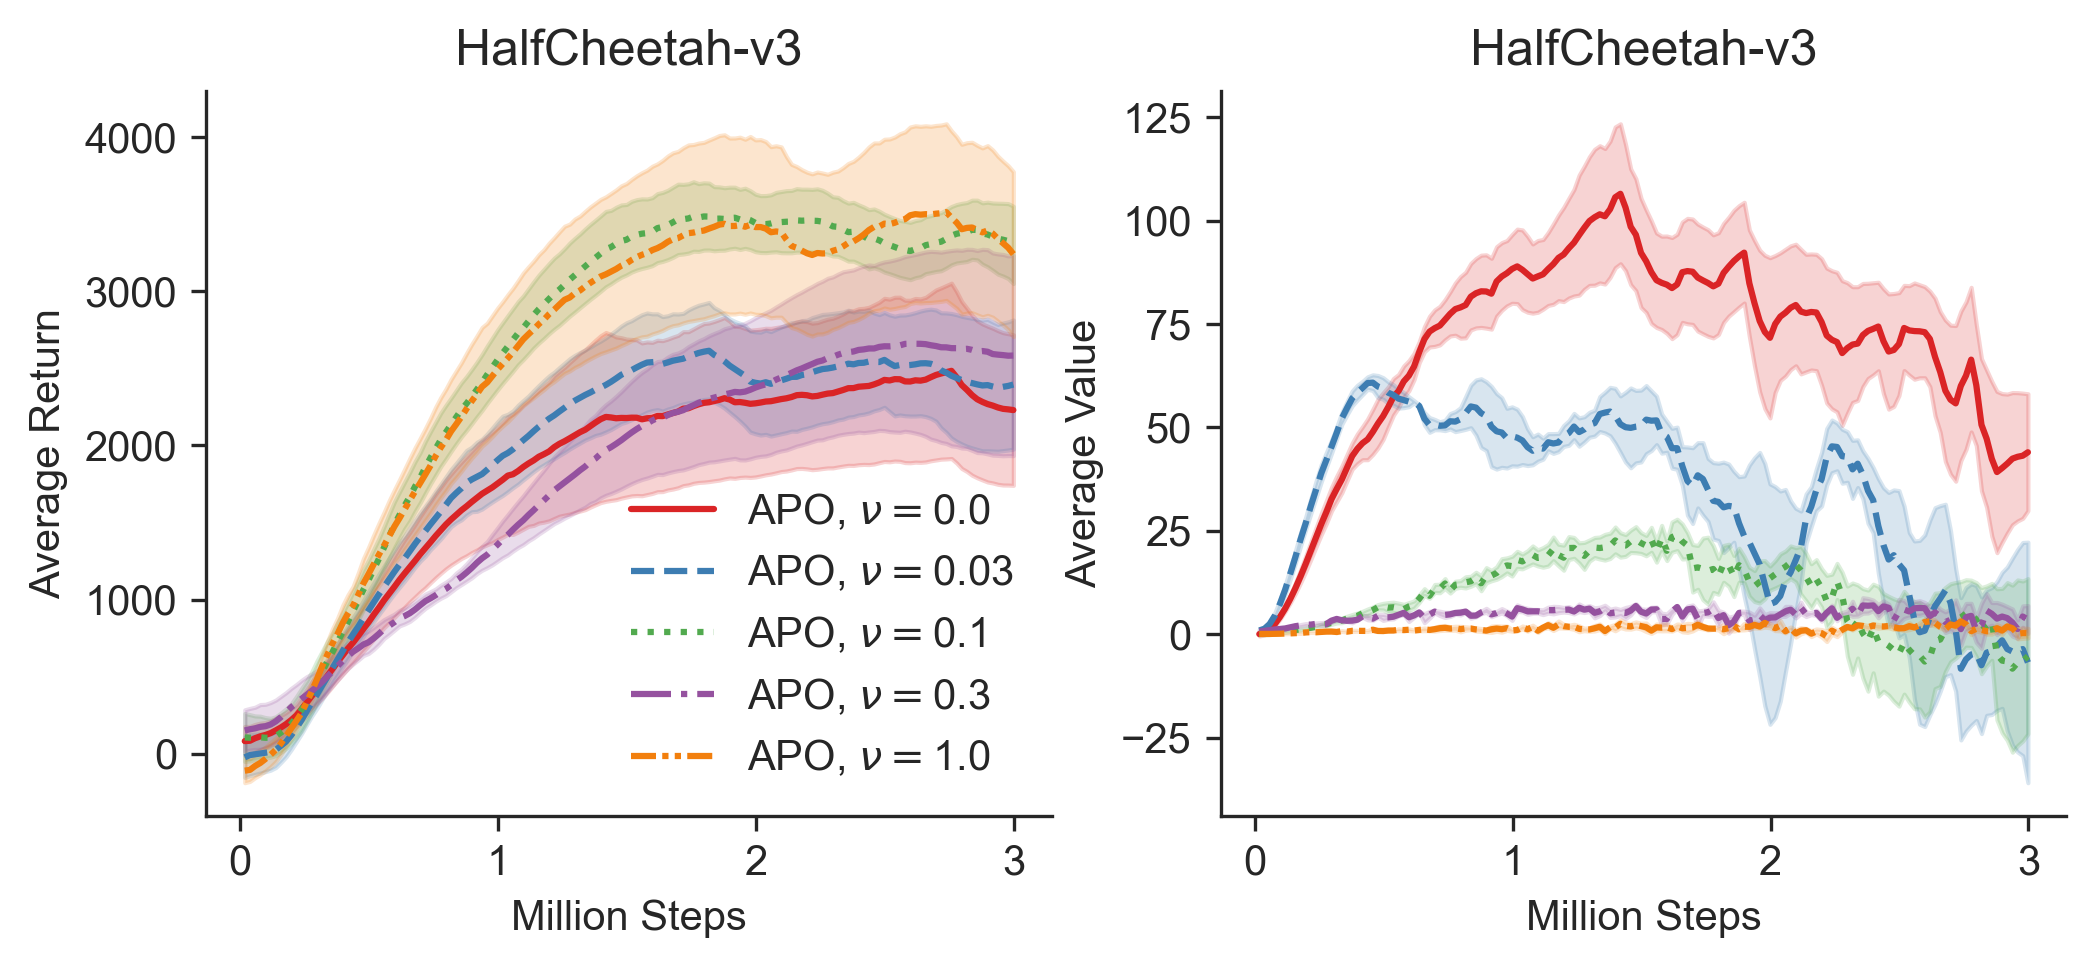

In [25]:
# compare APPO with different rm_vb_coef
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", (0, (4, 1, 1, 1, 1, 1))]
fig = plt.figure(figsize=(8, 3.2), dpi=300)
fig.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
env = "HalfCheetah-v3"
# env = "Swimmer-v3"
algo = "appo"

for i, rm_vb_coef in enumerate([0.0, 0.03, 0.1, 0.3, 1.0]):
    basedir = "exp_0107/data"
    steps_per_epoch = 2000
    setting = [s for s in best_settings_rm_vb_coef if env in s and f"_v-{rm_vb_coef}_" in s][0]
    print(setting)
    dfs = [
            pd.read_csv(os.path.join(basedir, setting, subdir, "progress.csv"))[1:]
            for subdir in os.listdir(os.path.join(basedir, setting))
            if subdir.startswith("run_") and not (algo == "appo" and subdir.startswith("run_0"))
        ]

    plot_curve(ax1, 
               dfs, 
               label=r"APO, $\nu=$" + str(rm_vb_coef), 
               color=COLORS[i], 
               linestyle=LINES[i],
               steps_per_epoch=steps_per_epoch, 
               context="Return/Average")
    ax1.set_title(env)
    ax1.set_xlabel("Million Steps")
    ax1.set_ylabel("Average Return")

    plot_curve(ax2, 
               dfs, 
               label=r"APO, $\nu=$" + str(rm_vb_coef), 
               color=COLORS[i],
               linestyle=LINES[i],
               steps_per_epoch=steps_per_epoch, 
               context="valueBias/Average")
    ax2.set_title(env)
    ax2.set_xlabel("Million Steps")
    ax2.set_ylabel("Average Value")

ax1.legend(loc="lower right", frameon=False)
sns.despine()
plt.show()
fig.savefig('result/value_bias.pdf', dpi=300, bbox_inches='tight')

In [42]:
algo = "appo"
discount_list = [1.0]
gae_lambda_list = [0.8, 0.9, 0.95, 0.99]
seed_list = [1, 2, 3, 4]
lr_eta_list = [0.03, 0.1, 0.3]
rm_vb_coef_list = [0.03, 0.1, 0.3, 1.0]
# env_list = ["Swimmer-v3", "HalfCheetah-v3", "Ant-v3", "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]
env_list = ["HalfCheetah-v3", "HalfCheetah-v3", "Ant-v3"] #, "Hopper-v3", "Walker2d-v3", "Humanoid-v3"]
from pprint import pprint
from itertools import product
basedir = "exp_0107/data"
improvements = []
for env, discount, gae_lambda, lr_eta in product(env_list, discount_list, gae_lambda_list, lr_eta_list):
    base, nu, nu_0 = [], [], []
    # nu=0
    setting = f"{algo}_g-{discount}_l-{gae_lambda}_e-{lr_eta}_v-0.0_{env}"
    for seed in seed_list:
        try:
            df = pd.read_csv(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
            base.append(df['Return/Average'][0])
            nu_0.append(df['Return/Average'].max())
        except:
            print(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))   
    base = np.nanmean(base)
    nu_0 = np.nanmean(nu_0)
    best_score = -np.inf
    for rm_vb_coef in rm_vb_coef_list:
        setting = f"{algo}_g-{discount}_l-{gae_lambda}_e-{lr_eta}_v-{rm_vb_coef}_{env}"
        score = []
        for seed in seed_list:
            try:
                # nu
                df = pd.read_csv(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
                score.append(df['Return/Average'].max())
            except:
                print(os.path.join(basedir, setting, f"run_{seed}", 'progress.csv'))
        score = np.nanmean(score)
        if score > best_score:
            best_score = score
        
    nu = best_score
    print(env, base, nu_0, nu, (nu - base) / (nu_0 - base) - 1)
    improvements.append((nu - base) / (nu_0 - base) - 1)
#     print(env, np.nanmean(improvements))
print(np.nanmean(improvements))

HalfCheetah-v3 -328.9908931110844 1580.913980754059 2508.203416118363 0.4855160317423113
HalfCheetah-v3 -328.9908931110844 2042.2975440114033 2407.7429744604497 0.15411260170968788
HalfCheetah-v3 -328.9908931110844 2072.9687752619884 2466.492078005797 0.16383426746309815
HalfCheetah-v3 -328.9908931110844 2296.9219219309016 3104.579458825875 0.3075721068378501
HalfCheetah-v3 -328.9908931110844 2661.1596681534247 3312.4886611623806 0.2178248150599862
HalfCheetah-v3 -328.9908931110844 2385.1719804868835 4040.3155916885935 0.6098173500574069
HalfCheetah-v3 -328.9908931110844 2275.260816902067 2351.615930558202 0.02931940617051554
HalfCheetah-v3 -328.9908931110844 2934.866217283985 3072.8682176342245 0.04228187560990837
HalfCheetah-v3 -328.9908931110844 1957.475854909348 4035.192247281651 0.908701774985855
HalfCheetah-v3 -328.9908931110844 862.2527919488173 1817.50293491725 0.8018931432324008
HalfCheetah-v3 -328.9908931110844 2054.5230913811247 1850.15275121909 -0.08574329393144897
HalfChee